## RNN Time Series Forecasting For Algorithmic Trading

In [3]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import hvplot
import hvplot.pandas

from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [4]:
#Reading closing prices of Devon Energy Corp.

data = pd.read_csv('DVN.csv')
data.set_index('Date',inplace=True)
data = data[['Close']]

In [5]:
data.head(10)

,Close
Date,
2015-02-17,66.650002
2015-02-18,63.950001
2015-02-19,64.410004
2015-02-20,63.820000
2015-02-23,63.950001
2015-02-24,64.839996
2015-02-25,65.449997
2015-02-26,62.549999
2015-02-27,61.590000


In [6]:
#Train and test sets

data.reset_index(inplace=True)
train = data.loc[data['Date'] <= '2018-04-27']
test = data.loc[data['Date'] > '2018-04-27']
train.set_index('Date',inplace=True)
test.set_index('Date',inplace=True)

In [7]:
train

,Close
Date,
2015-02-17,66.650002
2015-02-18,63.950001
2015-02-19,64.410004
2015-02-20,63.820000
2015-02-23,63.950001
...,...
2018-04-23,35.430000
2018-04-24,34.480000
2018-04-25,35.200001


In [8]:
test

,Close
Date,
2018-04-30,36.330002
2018-05-01,36.200001
2018-05-02,38.230000
2018-05-03,37.200001
2018-05-04,37.869999
...,...
2020-02-10,22.540001
2020-02-11,22.700001
2020-02-12,23.260000


## Exponential Moving Average Signal Construction

In [9]:
short_window = 10
long_window = 40

for stock_df in (test,train):
# Constructing a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    stock_df['fast_close'] = stock_df['Close'].ewm(halflife=short_window).mean()
    stock_df['slow_close'] = stock_df['Close'].ewm(halflife=long_window).mean()
    stock_df['Signal'] = 0.0


# Constructing a crossover trading signal
    stock_df['Signal'][short_window:] = np.where(
    stock_df['fast_close'][short_window:] > stock_df['slow_close'][short_window:], 1.0, 0.0
    )

    stock_df['Entry/Exit'] = stock_df['Signal'].diff()

/tmp/ipython-input-9-1577341990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['fast_close'] = stock_df['Close'].ewm(halflife=short_window).mean()
/tmp/ipython-input-9-1577341990.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['slow_close'] = stock_df['Close'].ewm(halflife=long_window).mean()
/tmp/ipython-input-9-1577341990.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [10]:
fast_close = list(train['fast_close'])
slow_close = list(train['slow_close'])
price = list(train['Close'])

<Axes: xlabel='Date'>

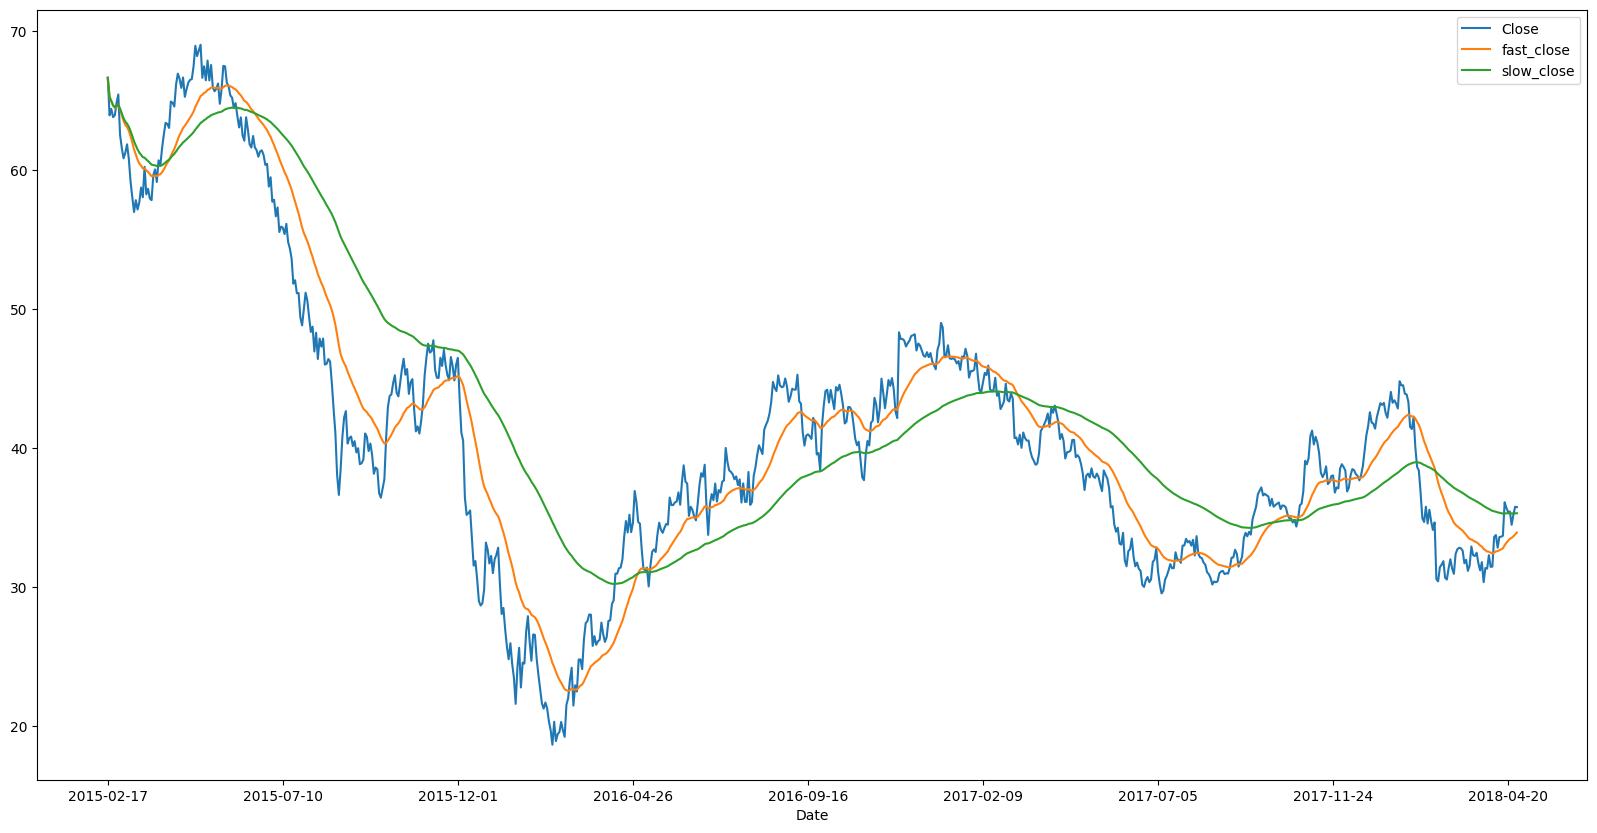

In [11]:
train[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

In [12]:
exit = test[test['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = test[test['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

security_close = test[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

moving_avgs = test[['slow_close', 'fast_close']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)


entry_exit_plot = moving_avgs*security_close * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [13]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(test)

                Close  fast_close  slow_close  Signal  Entry/Exit
Date                                                             
2018-04-30  36.330002   36.330002   36.330002     0.0         NaN
2018-05-01  36.200001   36.262750   36.264438     0.0         0.0
2018-05-02  38.230000   36.964441   36.931011     0.0         0.0
2018-05-03  37.200001   37.029588   37.000017     0.0         0.0
2018-05-04  37.869999   37.221739   37.180095     0.0         0.0
2018-05-07  37.889999   37.353266   37.303597     0.0         0.0
2018-05-08  39.020000   37.643609   37.561726     0.0         0.0
2018-05-09  40.220001   38.048949   37.914509     0.0         0.0
2018-05-10  40.889999   38.458885   38.268494     0.0         0.0
2018-05-11  40.950001   38.792530   38.558033     0.0         0.0
2018-05-14  41.320000   39.109798   38.831435     1.0         1.0
2018-05-15  41.279999   39.367148   39.055485     1.0         0.0
2018-05-16  41.400002   39.596379   39.255173     1.0         0.0
2018-05-17

In [14]:
#Generating lists to predict and real values to compare with predicted ones

def slice_dataframes(dataframe,from_date,to_date):
    dataframe.reset_index(inplace=True)
    limits = (dataframe['Date'] > from_date) & (dataframe['Date'] <= to_date)
    out_dataframe = dataframe.loc[limits]
    dataframe.set_index('Date',inplace=True)
    return out_dataframe

signal1 = slice_dataframes(test,'2019-02-22','2019-03-28')
signal2 = slice_dataframes(test,'2019-04-12','2019-05-17')
signal3 = slice_dataframes(test,'2019-11-15','2019-12-20')
signal4 = slice_dataframes(test,'2019-12-18','2020-01-24')
real1 = slice_dataframes(test,'2019-03-27','2019-04-04')
real2 = slice_dataframes(test,'2019-05-16','2019-05-24')
real3 = slice_dataframes(test,'2019-12-19','2019-12-30')
real4 = slice_dataframes(test,'2020-01-23','2020-01-31')


In [15]:
real4

,Date,Close,fast_close,slow_close,Signal,Entry/Exit
437,2020-01-24,23.950001,24.981584,24.396163,1.0,0.0
438,2020-01-27,22.620001,24.823436,24.365635,1.0,0.0
439,2020-01-28,22.719999,24.682575,24.337350,1.0,0.0
440,2020-01-29,22.190001,24.515655,24.300442,1.0,0.0
441,2020-01-30,22.490000,24.380003,24.269325,1.0,0.0
442,2020-01-31,21.719999,24.201871,24.225509,0.0,-1.0


In [16]:
#Signal dataframes are used to predict once the model is trained
signal1
signal2
signal3
signal4
#real dataframes have the sequence of real values used to be compared to predicted ones. On the real sequence of stock prices
#the signal1 list precedes the real1 list. together they are a sequence.
real1
real2
real3
real4

,Date,Close,fast_close,slow_close,Signal,Entry/Exit
437,2020-01-24,23.950001,24.981584,24.396163,1.0,0.0
438,2020-01-27,22.620001,24.823436,24.365635,1.0,0.0
439,2020-01-28,22.719999,24.682575,24.337350,1.0,0.0
440,2020-01-29,22.190001,24.515655,24.300442,1.0,0.0
441,2020-01-30,22.490000,24.380003,24.269325,1.0,0.0
442,2020-01-31,21.719999,24.201871,24.225509,0.0,-1.0


In [17]:
signal1

,Date,Close,fast_close,slow_close,Signal,Entry/Exit
206,2019-02-25,29.490000,27.359682,30.002264,0.0,0.0
207,2019-02-26,29.590000,27.509040,29.994983,0.0,0.0
208,2019-02-27,29.879999,27.667816,29.992953,0.0,0.0
209,2019-02-28,29.510000,27.791182,29.984433,0.0,0.0
210,2019-03-01,30.150000,27.949145,29.987352,0.0,0.0
211,2019-03-04,29.440001,28.048983,29.977704,0.0,0.0
212,2019-03-05,29.270000,28.130751,29.965235,0.0,0.0
213,2019-03-06,28.719999,28.170211,29.943305,0.0,0.0
214,2019-03-07,28.059999,28.162830,29.910152,0.0,0.0
215,2019-03-08,26.709999,28.065539,29.853842,0.0,0.0


In [18]:
#Converting dataframe columns into lists to fit the model once trained

def fast_slow_list(signal_list):
    fast_list = list(signal_list['fast_close'])
    slow_list = list(signal_list['slow_close'])
    close_list = list(signal_list['Close'])
    return fast_list, slow_list

#Values used to predict:
fast1, slow1 = fast_slow_list(signal1)
fast2, slow2 = fast_slow_list(signal2)
fast3, slow3 = fast_slow_list(signal3)
fast4, slow4 = fast_slow_list(signal4)

#Real sequences to be compared with future predicted sequences:
fast1_real, slow1_real = fast_slow_list(real1)
fast2_real, slow2_real = fast_slow_list(real2)
fast3_real, slow3_real = fast_slow_list(real3)
fast4_real, slow4_real = fast_slow_list(real4)

In [19]:
fast1_real

[29.64740939217196,
 29.77548981087189,
 29.893653858870426,
 29.98180556361249,
 30.0305705040355,
 30.096159972909632]

### MACD Calculation

This cell calculates the 12-day and 26-day EMAs, the MACD line, and the signal line, which will be used to prepare time-series input for the LSTM model.


In [36]:
# Calculate EMAs
train['EMA_12'] = train['Close'].ewm(span=12, adjust=False).mean()
train['EMA_26'] = train['Close'].ewm(span=26, adjust=False).mean()

# Calculate MACD and Signal Line
train['MACD'] = train['EMA_12'] - train['EMA_26']
train['Signal_Line'] = train['MACD'].ewm(span=9, adjust=False).mean()

# Visualize MACD vs Signal Line
train[['Close', 'MACD', 'Signal_Line']].hvplot(title='MACD and Signal Line')


/tmp/ipython-input-36-2369817915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['EMA_12'] = train['Close'].ewm(span=12, adjust=False).mean()
/tmp/ipython-input-36-2369817915.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['EMA_26'] = train['Close'].ewm(span=26, adjust=False).mean()
/tmp/ipython-input-36-2369817915.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [20]:
#training rnn model

def rnn_model(training_sequence):

    # split sequence
    def sequence_split(sequence, n_steps_in, n_steps_out):
        X, y = list(), list()
        for i in range(len(sequence)):
        # find end sequence
            end_ix = i + n_steps_in
            out_end_ix = end_ix + n_steps_out
            if out_end_ix > len(sequence):
                break
        # get features and targets
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
            X.append(seq_x)
            y.append(seq_y)
        return array(X), array(y)

    # sequence to train model on
    raw_seq = price
    # time steps
    n_steps_in, n_steps_out = 24, 6
    # getting samples
    X, y = sequence_split(raw_seq, n_steps_in, n_steps_out)
    # reshaping data to feed rnn
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    # defining the model
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    # fitting the model
    #model.fit(X, y, epochs=500, verbose=0)
    history = model.fit(X, y, epochs=500,steps_per_epoch=20,validation_steps=100,validation_split=0.2)
    return model

In [21]:
#generating two models one per each time series of EMA
model_fast = rnn_model(fast_close)
model_slow = rnn_model(slow_close)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 998.3121 - val_loss: 182.4523
Epoch 2/500
 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 308.2994

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 300.4126 - val_loss: 126.6669
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 175.1179 - val_loss: 217.5081
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 176.5177 - val_loss: 92.9662
Epoch 5/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 118.4275 - val_loss: 39.9487
Epoch 6/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 50.0345 - val_loss: 25.9946
Epoch 7/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 33.5903 - val_loss: 22.6949
Epoch 8/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 29.7394 - val_loss: 24.2489
Epoch 9/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 45.5169 - val_loss: 18.2520
Epoch 10/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 24.0033 - val_loss: 29.3101
Epoch 11/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 34.0440 - val_loss: 12.5805
Epoch 12/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 21.3322 - val_loss: 10.9060
Epoch 13/500
20/20 ━━━━━━━━━━━━━━━━

In [22]:
# making predictions

n_steps_in, n_steps_out = 24, 6
n_features = 1

def predict_sequence(past_sequence,model):
    temp_model = model
    x_input = array(past_sequence)
    x_input = x_input.reshape((1, n_steps_in, n_features))
    future = temp_model.predict(x_input, verbose=0)
    return future

fast1_predicted = predict_sequence(fast1,model_fast)
fast2_predicted = predict_sequence(fast2,model_fast)
fast3_predicted = predict_sequence(fast3,model_fast)
fast4_predicted = predict_sequence(fast4,model_fast)
slow1_predicted = predict_sequence(slow1,model_slow)
slow2_predicted = predict_sequence(slow2,model_slow)
slow3_predicted = predict_sequence(slow3,model_slow)
slow4_predicted = predict_sequence(slow4,model_slow)

In [23]:
fast1_predicted=fast1_predicted.tolist()
fast2_predicted=fast2_predicted.tolist()
fast3_predicted=fast3_predicted.tolist()
fast4_predicted=fast4_predicted.tolist()
slow1_predicted=slow1_predicted.tolist()
slow2_predicted=slow2_predicted.tolist()
slow3_predicted=slow3_predicted.tolist()
slow4_predicted=slow4_predicted.tolist()

In [24]:
fast1_predicted[0]

[29.601524353027344,
 29.62783432006836,
 29.418397903442383,
 29.273540496826172,
 29.421566009521484,
 29.651960372924805]

In [25]:
#Creating dataframes of results

d1= {'slow_real': slow1_real, 'slow_predicted': slow1_predicted[0], 'fast_real': fast1_real, 'fast_predicted': fast1_predicted[0]}
result_1_df = pd.DataFrame(data=d1)

d2 = {'slow_real': slow2_real, 'slow_predicted': slow2_predicted[0], 'fast_real': fast2_real, 'fast_predicted': fast2_predicted[0]}
result_2_df = pd.DataFrame(data=d2)

d3 = {'slow_real': slow3_real, 'slow_predicted': slow3_predicted[0], 'fast_real': fast3_real, 'fast_predicted': fast3_predicted[0]}
result_3_df = pd.DataFrame(data=d3)

d4 = {'slow_real': slow4_real, 'slow_predicted': slow4_predicted[0], 'fast_real': fast4_real, 'fast_predicted': fast4_predicted[0]}
result_4_df = pd.DataFrame(data=d4)

In [26]:
result_1_df

,slow_real,slow_predicted,fast_real,fast_predicted
0,29.974827,30.243349,29.647409,29.601524
1,30.002566,30.319431,29.775490,29.627834
2,30.029461,30.115812,29.893654,29.418398
3,30.050106,29.730465,29.981806,29.273540
4,30.061643,30.030159,30.030571,29.421566
5,30.078217,30.916073,30.096160,29.651960


In [27]:
result_2_df

,slow_real,slow_predicted,fast_real,fast_predicted
0,30.866044,31.128794,31.476596,31.868700
1,30.851536,31.243954,31.379722,31.643484
2,30.856194,31.018074,31.362329,31.553396
3,30.829373,30.608288,31.224891,31.176214
4,30.765908,31.024237,30.953347,31.124523
5,30.700431,31.820192,30.687933,31.318398


In [28]:
result_3_df

,slow_real,slow_predicted,fast_real,fast_predicted
0,23.814729,23.723536,23.192680,24.599775
1,23.856252,22.128225,23.396080,25.150301
2,23.902390,22.193508,23.606619,25.388062
3,23.944640,22.413952,23.791005,25.517780
4,23.975333,22.125109,23.920854,25.911547
5,24.002059,22.364956,24.028613,26.643881


In [29]:
result_4_df

,slow_real,slow_predicted,fast_real,fast_predicted
0,24.396163,24.371359,24.981584,25.606600
1,24.365635,22.820669,24.823436,26.141483
2,24.337350,22.971546,24.682575,26.011274
3,24.300442,23.217682,24.515655,26.045740
4,24.269325,22.750561,24.380003,26.443611
5,24.225509,23.110121,24.201871,27.061054


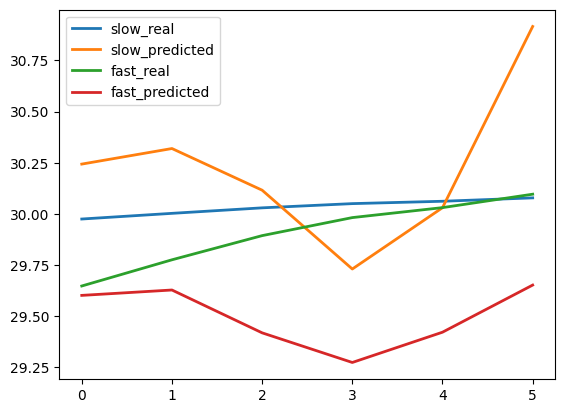

In [30]:
result_1_df.plot(lw=2);

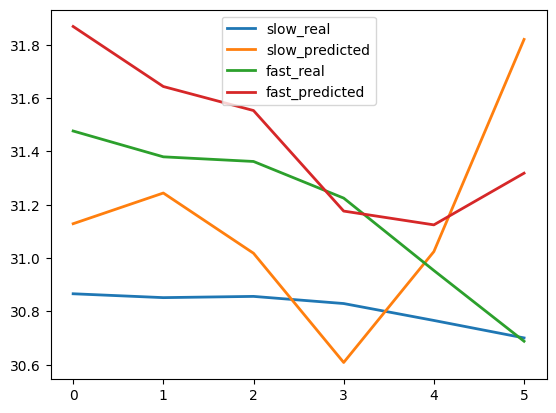

In [31]:
result_2_df.plot(lw=2);

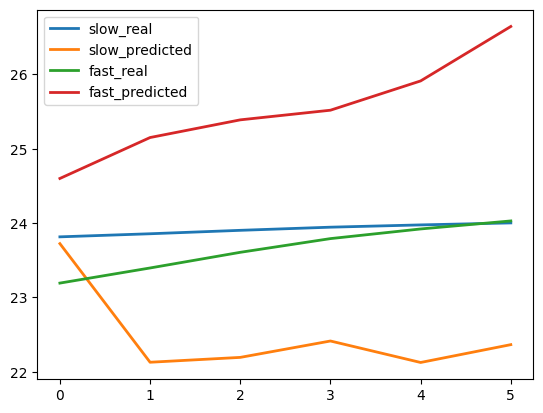

In [32]:
result_3_df.plot(lw=2);

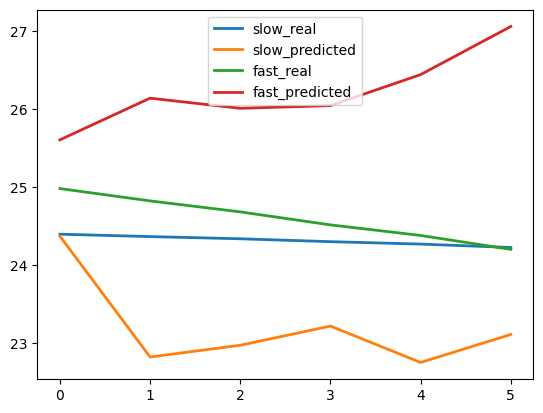

In [33]:
result_4_df.plot(lw=2);